In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

## Classification

In this notebook, our goal will be to find the parameter vector $\vec{\hat{\beta}}$ that minimizes our empirical risk $R(\vec{\beta}, \Bbb{x}, \vec{y})$, where $\Bbb{X}$ is our design matrix and $\vec{y}$ are our observed classes. That is we want:

$$
\vec{\hat\beta} = \text{argmin}_{\vec{\beta}} R(\vec{\beta}, \Bbb{x}, \vec{y}) = \text{argmin}_{\vec{\beta}} \dfrac{1}{n}
\sum_i \ell(y_i, \hat{y}_i) $$

In this notebook, we'll choose the logistic regression model $\hat{y}_i = \sigma(\Bbb{X}_i^T \vec{\beta})$ to produce our predicted probability. Here $\Bbb{X}_i$ is the ith row of the design matrix. (Note: In keeping with common mathematical convention, the row is given as a column vector, hence $\Bbb{X}_i^T \vec{\beta}$ is just the dot product of the ith row of $\Bbb{X}$ and $\vec{\beta}$. I also think it is weird that rows are given as column vectors, but oh well).

In other words, we can write the expression above as:

$$
\vec{\hat\beta} = \text{argmin}_{\vec{\beta}} R(\vec{\beta}, \Bbb{x}, \vec{y}) = \text{argmin}_{\vec{\beta}} \dfrac{1}{n}
\sum_i \ell(y_i, \sigma(\Bbb{X}_i^T \vec{\beta})) $$

In this problem, we'll choose $\ell$ to be the cross entropy loss. That is, the empirical risk will be the average cross entropy loss across all observations.

$$\ell(y_i, \hat{y}_i) =  -y_i \log(\hat{y}_i) - (1 - y_i) \log(1 - \hat{y}_i)) 
$$

$\sigma(\Bbb{X}_i^T \vec{\beta})$, $\ell(y_i, \hat{y}_i)$, and $R(\vec{\beta}, \Bbb{x}, \vec{y})$ can all be computed using the code below.

In [2]:
def sigma(t):
    """The logistic or sigmoid function, denoted σ(t).
    
    Note: This is actually a special case of what is generally 
          named the "logistic" function,
          which allows for a different numerator and offset, 
          but lots of people call this the logistic function in practice.
    """
    return 1 / (1 + np.exp(-t))

def prediction(X, beta): # this is sigma(x dot beta)
    """Prediction under the logistic model for features x and parameters b."""
    return sigma(X @ beta)


def cross_entropy_loss(y, y_hat): #this is l(y, y_hat)
    """Log loss or cross-entropy loss, assuming y is in [0, 1]."""
    assert y in [0, 1]
    return -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)

def average_cross_entropy_loss(beta, X, y_obs): # this is R(beta, X, y)
    """The average cross entropy loss."""
    y_hat = sigma(X @ beta)
    losses = [cross_entropy_loss(y_obs_i, y_hat_i) for y_obs_i, y_hat_i in zip(y_obs, y_hat)]
    return np.average(losses)


## Optimizing With Brute Force Guess and Check

Let's consider a cancer dataset.

In [3]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
cancer = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])

#put bias column at the front of the dataframe
cancer.insert(0, 'bias', 1.0)


# Target data_dict['target'] = 0 is malignant; 1 is benign
cancer['malignant'] = 1 - data_dict['target']
cancer.iloc[0]

bias                          1.000000
mean radius                  17.990000
mean texture                 10.380000
mean perimeter              122.800000
mean area                  1001.000000
mean smoothness               0.118400
mean compactness              0.277600
mean concavity                0.300100
mean concave points           0.147100
mean symmetry                 0.241900
mean fractal dimension        0.078710
radius error                  1.095000
texture error                 0.905300
perimeter error               8.589000
area error                  153.400000
smoothness error              0.006399
compactness error             0.049040
concavity error               0.053730
concave points error          0.015870
symmetry error                0.030030
fractal dimension error       0.006193
worst radius                 25.380000
worst texture                17.330000
worst perimeter             184.600000
worst area                 2019.000000
worst smoothness         

In [4]:
cancer.describe()

,bias,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,malignant
count,569.0,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,1.0,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.372583
std,0.0,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,1.0,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,1.0,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,1.0,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,0.000000
75%,1.0,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,1.0,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cancer, test_size=0.25, random_state=100)
print("Training Data Size: ", len(train))
print("Test Data Size: ", len(test))

Training Data Size:  426
Test Data Size:  143


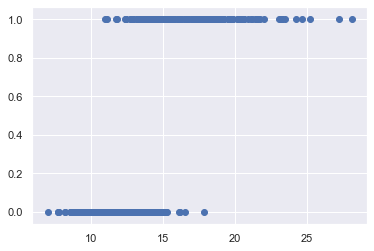

In [6]:
plt.scatter(train['mean radius'], train['malignant']);

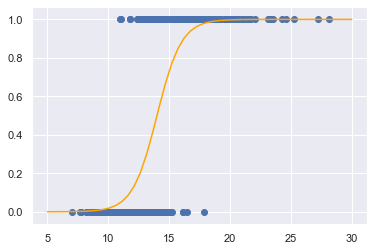

In [7]:
beta1 = -14
beta2 = 1
radii = np.linspace(5, 30, 50)
plt.scatter(train['mean radius'], train['malignant']);
plt.plot(radii, sigma(beta1 + radii * beta2), 'orange');

To evaluate the quality of a beta, we can also create a function that computes the empirical risk, in this case the cross entropy loss.

To do this, we need to create a design matrix. For now, let's create a design matrix with two columns. The first column will be the bias, and second will be the mean radius. Since we only have one meaningful feature, we call this `X_1f_train`.

In [8]:
def create_radius_and_bias_design_matrix(t):
    """Returns a design matrix with just 1 feature (radius) and a bias term"""
    return t[['bias', 'mean radius']].values
    
X_1f_train = create_radius_and_bias_design_matrix(train)

In [9]:
X_1f_train.shape

(426, 2)

In [10]:
X_1f_train[0:5, :]

array([[  1.  ,  12.63],
       [  1.  ,  13.71],
       [  1.  ,  10.26],
       [  1.  ,  10.95],
       [  1.  ,  15.37]])

Similarly, we'll also want to create a convenient vector of our training data.

In [11]:
y_train = train['malignant'].values

In [12]:
y_train[0:5]

array([0, 0, 0, 1, 1])

Using our `average_cross_entropy_loss` function defined above, we can in principle find the optimal beta through brute force guess and check.

In [13]:
average_cross_entropy_loss(np.array([-14.5, 1]), X_1f_train, y_train)

0.30259113309678815

## Optimizing With Gradient Descent

Optimizing gradient descent means traversing the 2D loss surface shown below, where one coordinate is the weight of the intercept term, and the other is the weight of the mean radius.

In [14]:
import plotly.graph_objects as go

num_points = 10
uvalues = np.linspace(-16, -12, num_points)
vvalues = np.linspace(0, 1.3, num_points)
(u,v) = np.meshgrid(uvalues, vvalues)
betas = np.vstack((u.flatten(),v.flatten()))

losses = np.array([average_cross_entropy_loss(b, X_1f_train, y_train) for b in betas.T])
loss_surface = go.Surface(x=u, y=v, z=np.reshape(losses, u.shape))

fig = go.Figure(data=[loss_surface])
fig.update_layout(scene = dict(
    xaxis_title = "beta1",
    yaxis_title = "beta2",
    zaxis_title = "Mean CE Loss"))
fig.show()


ModuleNotFoundError: No module named 'plotly.graph_objects'

To use gradient descent to solve this problem, we need the gradient of our empirical risk, i.e. the average cross entropy loss. The function below yields the gradient of the function above.

In [ ]:
def risk_gradient(beta, X, y):
    """Gradient of the cross entropy loss.
       Here X is our design matrix, and y is a vector of observations, 
       one for each row of the design matrix."""
    n = X.shape[0]
    return -(1/n) * X.T @ (y - sigma(X @ beta)) 

For example at beta1 = -14, beta2 = 0.5 is `[-0.3588, -6.18]`, implying we should sharply increase beta2 and slightly increase beta1. This matches what we'd expect from the plot above.

In [ ]:
risk_gradient(np.array([-14, 0.5]), X_1f_train, y_train)

Where did this magic python function come from? It starts from the definition of the gradient of our risk function.

$$\nabla_{\vec{\beta}} R(\vec{\beta}, \Bbb{x}, \vec{y}) = \nabla_{\vec{\beta}}\dfrac{1}{n}
\sum_i \ell(y_i, \sigma(\vec{x}_i^T \vec{\beta})) $$

From there, after a ton of fairly boring algebra (i.e. start by substituting in $\ell(y_i, \hat{y}_i) =  -y_i \log(\hat{y}_i) - (1 - y_i) \log(1 - \hat{y}_i))$), we arrive at the symbolic expression below.

$$\nabla_{\vec{\beta}} R(\vec{\beta}, \Bbb{x}, \vec{y}) = - \frac{1}{n}\sum_{i=1}^n \left(y_i - \sigma(x_i^T\beta)\right) x_i$$

The details of this derivation are at the end of this notebook if you're curious.

In [101]:
def risk_gradient_slow(beta, X, y):
    """Gradient of our empirical risk. Here X is our design matrix, and y is a vector of observations, one
       for each row of the design matrix."""
    n = X.shape[0]
    total_ce_loss = 0
    for i in range(X.shape[0]):
        total_ce_loss += (y[i] - sigma(np.dot(X[i, :], beta))) * X[i, :]
    return -(1/n) * total_ce_loss

Unfortunately this code is extremely slow because of its use of for loops. With a little matix multiplication magic, we can get the much faster implementation below. The reason the matrix multiplication based version is faster is beyond the scope of our class.

Note: It's fairly challenging to convert the code above into the matrix multiplication form below. This is not something we expect you to be comforable doing and takes a lot of practice.

In [102]:
def risk_gradient(beta, X, y):
    """Gradient of our empirical risk. Here X is our design matrix, and y is a vector of observations, one
       for each row of the design matrix."""
    n = X.shape[0]
    return -(1/n) * X.T @ (y - sigma(X @ beta)) 

We can also plot the gradient using a quiver plot:

In [172]:
import plotly.graph_objects as go
import plotly.figure_factory as ff


num_points = 10
uvalues = np.linspace(-16, -12, num_points)
vvalues = np.linspace(0, 1.3, num_points)
(u,v) = np.meshgrid(uvalues, vvalues)
betas = np.vstack((u.flatten(),v.flatten()))

gradients = np.array([risk_gradient(b, X_1f_train, y_train) for b in betas.T])
gradients_u = np.reshape(gradients[:, 0], u.shape)
gradients_v = np.reshape(gradients[:, 1], u.shape)

fig = ff.create_quiver(u, v, gradients_u, gradients_v,
                       scale=.1,
                       arrow_scale=.4,
                       name='quiver',
                       line_width=1)

fig.show()


## Solving With Gradient Descent

Below we have implemented our gradient descent algorithm. This version is very similar to the version of gradient descent with a decaying learning rate that you implemented in hw7. 

This version also has a call to `np.clip`, which is used to keep the algorithm from making too large of a jump. Specifically `np.clip(grad, -clip, clip)` returns `-clip` if `grad` is less than `-clip` and returns `clip` if `grad` is greater than `clip`.

This technique is known as "gradient clipping". 

In [202]:
def gradient_descent(X, y, beta0, gradient_function, max_iter=100000,  
                     epsilon=1e-8, lr=1, clip=1):
    """Run gradient descent on a dataset (x, y) 
    with gradient clipping and learning rate decay."""
    beta = beta0
    for t in range(1, max_iter):
        grad = gradient_function(beta, X, y)
       # print(f"grad: {grad}, beta: {beta}")
        
        beta = beta - (lr/(1 + t/1000)) * np.clip(grad, -clip, clip) 
        # Detect approximate convergence: small gradient
        if np.linalg.norm(grad) < epsilon:
            print(f"Completed in {t} iterations, norm of gradient is {np.linalg.norm(grad)}")
            return beta
    print(f"Completed in {t} iterations, norm of gradient is {np.linalg.norm(grad)}")
    return beta


Given the `gradient_descent` and `risk_gradient` functions defined above, it is trivial to write a function that will fit a logistic regression model:

In [207]:
def logistic_regression(X, y, lr=1):
    """Train a logistic regression classifier using gradient descent."""
    beta0 = np.zeros(X.shape[1])
    beta = gradient_descent(X, y, beta0, risk_gradient, lr=lr)
    return beta    

In [208]:
%%time
beta_1f = logistic_regression(X_1f_train, y_train)
print(f"optimal beta is approximately {beta_1f}")

Completed in 99999 iterations, norm of gradient is 0.0008482375791765371
optimal beta is approximately [-14.13203913   0.95705058]
CPU times: user 17.4 s, sys: 62.5 ms, total: 17.5 s
Wall time: 17.8 s


In [209]:
risk_gradient(beta_1f, X_1f_train, y_train)

array([ 8.46155266e-04, -5.92575489e-05])

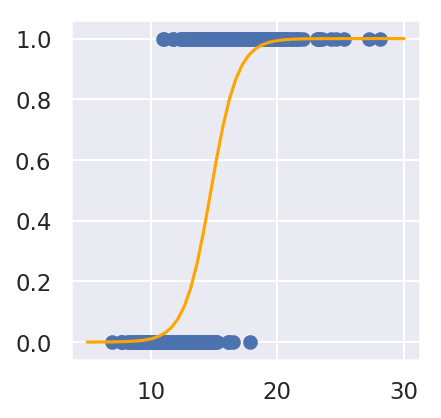

In [178]:
radii = np.linspace(5, 30, 50)
plt.scatter(train['mean radius'], train['malignant']);
plt.plot(radii, sigma(beta_1f[0] + radii * beta_1f[1]), 'orange');

In [179]:
average_cross_entropy_loss(beta_1f, X_1f_train, y_train)

0.29998088634608877

## Let's Compare With Scikit Learn

In [180]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept=False, C=1e9, solver='lbfgs')
model.fit(X_1f_train, y_train)
model.coef_

array([[-14.8970826 ,   1.01064211]])

In [181]:
average_cross_entropy_loss(model.coef_[0], X_1f_train, y_train)

0.2996624823521378

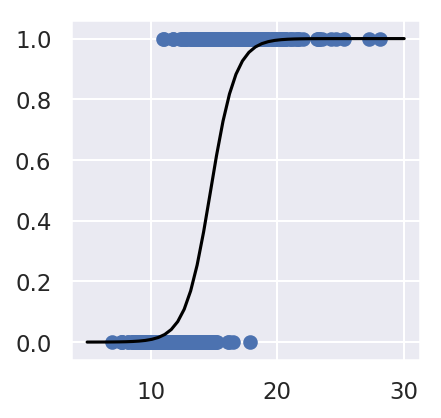

In [112]:
plt.scatter(train['mean radius'], train['malignant']);
plt.plot(radii, sigma(model.coef_[0,0] + radii * model.coef_[0,1]), 'black');

As you can see, our model is quite similar! What we've learned in this course does really get us the same result as scikit learn.

## Using Feature Scaling to Accelerate Gradient Descent

Our gradient descent algorithm took a long time to converge. On my laptop it takes 15 seconds.

If we center and scale our data, gradient descent will tend to converge much more quickly. This is because if our features are of different scales, the size of the steps we need to take in each dimension can be quite different. 

By bringing everything into the same scale, we avoid this problem.

One approach is to center and scale our data manually. Note that we do not center and scale the bias column, otherwise it will be zeroed out.

In [114]:
X_1f_scaled_train = X_1f_train.copy()

X_1f_scaled_train[:, 1] = (X_1f_scaled_train[:, 1] - np.mean(X_1f_scaled_train[:, 1])) / np.std(X_1f_scaled_train[:, 1])
X_1f_scaled_train[0:5, :]

array([[ 1.        , -0.40016643],
       [ 1.        , -0.09151733],
       [ 1.        , -1.07747972],
       [ 1.        , -0.88028724],
       [ 1.        ,  0.38288777]])

Alternately we can use the sklearn standard scaler, which does the same thing.

In [115]:
from sklearn import preprocessing

def train_scaler_that_ignores_bias(X_train):
    """Assumes there is a bias column in X_train[:, 0]"""
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)

    # force scaler to ignore the bias term
    scaler.var_[0] = 0
    scaler.mean_[0] = 0
    scaler.scale_[0] = 1
    return scaler

X_1f_scaler = train_scaler_that_ignores_bias(X_1f_train)

In [182]:
X_1f_scaled_train = X_1f_scaler.transform(X_1f_train)

In [183]:
X_1f_scaled_train[0:5, :]

array([[ 1.        , -0.40016643],
       [ 1.        , -0.09151733],
       [ 1.        , -1.07747972],
       [ 1.        , -0.88028724],
       [ 1.        ,  0.38288777]])

If we run gradient descent on the scaled training data, we see that our code is much much faster, completing in a fraction of a secnd.

In [210]:
%%time
beta_1f_scaled = logistic_regression(X_1f_scaled_train, y_train)
print(f"optimal beta is approximately {beta_1f_scaled}")

Completed in 1331 iterations, norm of gradient is 9.950949397773562e-09
optimal beta is approximately [-0.71754814  3.53645544]
CPU times: user 234 ms, sys: 31.2 ms, total: 266 ms
Wall time: 241 ms


Note: The beta we get back is different, because the data is different. The empirical risks, however, are quite similar, with our scaled version achieving slightly better results.

In [193]:
average_cross_entropy_loss(beta_1f, X_1f_train, y_train)

0.29998088634608877

In [194]:
average_cross_entropy_loss(beta_1f_scaled, X_1f_scaled_train, y_train)

0.299662482267711

The quiver plot below gives some insight into why the gradient descent is faster. We see that both components of the gradient are of roughly the same scale (i.e. our lines look more diagonal than straight).

In [195]:
import plotly.graph_objects as go
import plotly.figure_factory as ff


num_points = 10
uvalues = np.linspace(-8, 8, num_points)
vvalues = np.linspace(-8, 8, num_points)
(u,v) = np.meshgrid(uvalues, vvalues)
betas = np.vstack((u.flatten(),v.flatten()))

gradients = np.array([risk_gradient(b, X_1f_scaled_train, y_train) for b in betas.T])
gradients_u = np.reshape(gradients[:, 0], u.shape)
gradients_v = np.reshape(gradients[:, 1], u.shape)

fig = ff.create_quiver(u, v, gradients_u, gradients_v,
                       scale=1,
                       arrow_scale=.4,
                       name='quiver',
                       line_width=1)

fig.show()


## Assessing the Quality of our Classifier

First we define a function `print_accuracy` that will print the accuracy of our model based on the given x data, y data, beta, and classification threshold.

In [196]:
def print_ratio(n, d, prefix = ""):
    """Prints the ratio of the two given quantities"""
    print(f'{prefix}{n}/{d} ({100 * n/d:.1f}%)')

def print_accuracy(X, y_obs, beta, threshold, prefix = ""):
    """Prints the accuracy of a logistic classifier trained on the
       given x, y_obs data using the provided beta and threshold"""
    y_hat = sigma(X @ beta) > threshold
    guesses = np.round(y_hat)
    correct = y_obs == guesses
    print_ratio(sum(correct), len(guesses), prefix)

Below we see that our model that we trained using gradient descent gets around 87% accuracy on the training set with a threshold of 0.5.

In [122]:
print_accuracy(X_1f_train, y_train, beta_1f, 0.5, "Train Accuracy: ")

Train Accuracy: 371/426 (87.1%)


Or using our scaled version:

In [123]:
print_accuracy(X_1f_scaled_train, y_train, beta_1f_scaled, 0.5, "Train Accuracy: ")

Train Accuracy: 370/426 (86.9%)


Below we put our test data in the `x_test` and `y_test` variables, and observe that 60.8% of the observations are malignant. Because we have a relatively balanced test set, accuracy should give us a fairly good picture of performance.

In [124]:
X_1f_test = create_radius_and_bias_design_matrix(test)
y_test = test['malignant'].values
print_ratio(sum(1-y_test), len(y_test), "Fraction Malignant in Test Set: ")

Fraction Malignant in Test Set: 87/143 (60.8%)


On this test set, we see our unscaled model gets 91% accuracy.

In [125]:
print_accuracy(X_1f_test, y_test, beta_1f, 0.5, "Test Accuracy: ")

Test Accuracy: 130/143 (90.9%)


And our scaled model gets the exact same accuracy.

In [127]:
X_1f_scaled_test = X_1f_scaler.transform(X_1f_test)

In [128]:
print_accuracy(X_1f_scaled_test, y_test, beta_1f_scaled, 0.5, "Test Accuracy: ")

Test Accuracy: 130/143 (90.9%)


#### Brief Digression

The careful reader will observe that the X_1f_scaler object used to create X_1f_scaled_test was created using the training set, not the test set. 

That means that the radius in our `X_1f_scaled_test` data will not actually have zero mean or unit variance. Instead we see the average radius in our scaled test set is 0.11 and the variance is 1.02.

In [129]:
np.mean(X_1f_scaled_test, axis = 0)

array([1.        , 0.11037364])

In [130]:
np.std(X_1f_scaled_test, axis = 0)

array([0.        , 1.02013996])

This is a good thing! The model was built using units derived from the training data, not the test data.

If you'd like, check the accuracy of the model if we center and scale our test data using the test mean and std. You'll see it's somewhat worse.

On large samples where the training and test were drawn from the same population there won't be much of a difference, but in this example, the difference is noticeable because the dataset is small.

#### End of Digression, Back to Model Quality Assessment

To summarize the quality of a given beta on a given training and test set, we will define the handy utility function `print_test_and_train_accuracy` which shows the training and test accuracy for the given `beta` on the provided data.

In [197]:
def print_test_and_train_accuracy(beta, X_train, y_train, X_test, y_test):
    print_accuracy(X_train, y_train, beta, 0.5, "Train Accuracy: ")
    print_accuracy(X_test, y_test, beta, 0.5, "Test Accuracy: ")

For example, we can use this function to summarize the performance of our model, which uses only the radius and a bias term.

In [198]:
print_test_and_train_accuracy(beta_1f_scaled, X_1f_scaled_train, y_train, X_1f_scaled_test, y_test)

Train Accuracy: 370/426 (86.9%)
Test Accuracy: 130/143 (90.9%)


Let's see how a model trained on all available features performs. Let's start by defining a design matrix that uses all features.

In [133]:
def create_all_feature_design_matrix(t):
    """Creates a design matrix that uses all features except for the right answer."""
    return t.drop('malignant', axis=1).values

X_allf_train = create_all_feature_design_matrix(train)
X_allf_test =  create_all_feature_design_matrix(test)

In [134]:
X_allf_train.shape

(426, 31)

In [135]:
X_allf_train[0:2, :]

array([[1.000e+00, 1.263e+01, 2.076e+01, 8.215e+01, 4.804e+02, 9.933e-02,
        1.209e-01, 1.065e-01, 6.021e-02, 1.735e-01, 7.070e-02, 3.424e-01,
        1.803e+00, 2.711e+00, 2.048e+01, 1.291e-02, 4.042e-02, 5.101e-02,
        2.295e-02, 2.144e-02, 5.891e-03, 1.333e+01, 2.547e+01, 8.900e+01,
        5.274e+02, 1.287e-01, 2.250e-01, 2.216e-01, 1.105e-01, 2.226e-01,
        8.486e-02],
       [1.000e+00, 1.371e+01, 1.868e+01, 8.873e+01, 5.710e+02, 9.916e-02,
        1.070e-01, 5.385e-02, 3.783e-02, 1.714e-01, 6.843e-02, 3.191e-01,
        1.249e+00, 2.284e+00, 2.645e+01, 6.739e-03, 2.251e-02, 2.086e-02,
        1.352e-02, 1.870e-02, 3.747e-03, 1.511e+01, 2.563e+01, 9.943e+01,
        7.019e+02, 1.425e-01, 2.566e-01, 1.935e-01, 1.284e-01, 2.849e-01,
        9.031e-02]])

As before, we scale our data so that gradient descent will complete more quickly.

In [199]:
X_allf_scaler = train_scaler_that_ignores_bias(X_allf_train)

In [200]:
X_allf_scaled_train  = X_allf_scaler.transform(X_allf_train)
X_allf_scaled_test  = X_allf_scaler.transform(X_allf_test)

In [138]:
X_allf_scaled_train[0:2, :]

array([[ 1.        , -0.40016643,  0.34471677, -0.37980495, -0.47716792,
         0.23498099,  0.34703847,  0.27330103,  0.32195529, -0.26482442,
         1.17169325, -0.22082134,  1.01524506, -0.06269651, -0.4530114 ,
         1.8875189 ,  0.82686744,  0.74284158,  1.85286562,  0.09488428,
         0.81597281, -0.58907559, -0.02953003, -0.52450369, -0.61623851,
        -0.13927685, -0.166986  , -0.21350526, -0.04438005, -1.13586608,
         0.06583523],
       [ 1.        , -0.09151733, -0.14480458, -0.10586151, -0.21489406,
         0.22247708,  0.07163644, -0.43321005, -0.27279167, -0.34588647,
         0.83506685, -0.30937255,  0.03139068, -0.28588371, -0.30846669,
        -0.12048906, -0.17311202, -0.39270267,  0.27703554, -0.2448772 ,
        -0.0311098 , -0.21124974, -0.00308453, -0.20419842, -0.29311679,
         0.48760813,  0.03931744, -0.35442614,  0.23300959, -0.05034187,
         0.37866712]])

Using `print_test_and_train_accuracy` on a feature set that includes all available features, we see we get better training and test error.

In [139]:
print_test_and_train_accuracy(beta_1f_scaled, X_1f_scaled_train, y_train, X_1f_scaled_test, y_test)

Train Accuracy: 370/426 (86.9%)
Test Accuracy: 130/143 (90.9%)


In [211]:
%%time
beta_allf_scaled = logistic_regression(X_allf_scaled_train, y_train, lr=10)
print_test_and_train_accuracy(beta_allf_scaled, X_allf_scaled_train, y_train, X_allf_scaled_test, y_test)

Completed in 99999 iterations, norm of gradient is 0.0003529669400620736
Train Accuracy: 426/426 (100.0%)
Test Accuracy: 134/143 (93.7%)
CPU times: user 1min 48s, sys: 1min 36s, total: 3min 24s
Wall time: 33.5 s


We see that we have achieved 100% accuracy on our training set. This means that the data is linearly separable. 

As a result, the betas are quite large for a logistic regression model, e.g. one of them is greater than 16.

In [204]:
beta_allf_scaled

array([  2.15277182,  -4.16836775,  -2.0746336 ,  -2.63839969,
        -2.00715374,   3.09760169, -11.56550051,   5.71852387,
         8.19448688,  -3.40419765,  -3.46098538,   8.3595231 ,
        -2.99249773,   0.48449704,  16.21351354,   0.54434541,
         0.73152425,  -5.59049671,   9.47024877,   3.35158481,
       -11.84465888,   3.57230995,   9.76675742,   6.47211394,
         6.12690779,   2.78259362,  -3.2889228 ,   5.80220893,
         2.61788599,  -0.57666457,  14.88615644])

To deal with this, we can employ regularization.

### Regularized Logistic Regression

As with linear regression, one common way of reducing the variance of the parameter estimator is to add a regularization term to the empirical risk objective, e.g.:

\begin{align*}
R(\beta, x, y, \lambda) &= - \frac{1}{n}\sum_{i=1}^n \left[ y_i x_i^T\beta + \log \sigma(-x_i^T\beta) \right] + \lambda \sum_{j=1}^J \beta_j^2 \\[10pt]
\nabla_{\beta} R(\beta, x, y, \lambda) &=  - \frac{1}{n}\sum_{i=1}^n \left(y_i - \sigma(x_i^T\beta)\right) x_i + 2 \lambda \beta \\[10pt]
\end{align*}

Let's try to find the lambda which yields the best accuracy for this regularized model. 

**Note:** When using regularization, we do not include the $\beta_1$ corresponding to our bias term. This is because a large $\beta_1$ is not overemphasizing any specific feature and is instead simply a fixed offset.

**Note:** We have arbitrarily chosen accuracy here to evaluate the quality of our parameters. We could use other characterizations, e.g. average cross entropy loss, ROC curves, area under ROC curves, precision recall curves, etc.

**Note:** In the example below, we compute the test error directly to assess the quality of a given hyperparameter lambda. In a real world setting, we would probably use cross validation instead.

In [213]:
def regularized_logistic_regression(X, y, lam, lr):
    """Train a logistic regression classifier using gradient descent."""

    def l2_regularized_gradient(beta, X, y, lr=lr):
        non_bias_betas = np.hstack(([0], beta[1:]))
        return risk_gradient(beta, X, y) + 2 * lam * non_bias_betas

    beta0 = np.zeros(X.shape[1])
    beta = gradient_descent(X, y, beta0, l2_regularized_gradient, lr=lr)
    return beta    

def search_for_lambda(X_train, y_train, X_test, y_test, lambdas):
    for lam in lambdas:
        print("lambda =", lam)
        beta = regularized_logistic_regression(X_train, y_train, lam, 10)
        print("sum(beta**2) = ", sum(beta**2))
        print_test_and_train_accuracy(beta, X_train, y_train, X_test, y_test)
        print()
        

lambdas = np.hstack(([0], 10.0 ** np.linspace(-5, 0, 6)))
search_for_lambda(X_allf_scaled_train, y_train, X_allf_scaled_test, y_test, lambdas)

lambda = 0.0
Completed in 99999 iterations, norm of gradient is 0.0003529669400620736
sum(beta**2) =  1387.9140857705347
Train Accuracy: 426/426 (100.0%)
Test Accuracy: 134/143 (93.7%)

lambda = 1e-05
Completed in 99999 iterations, norm of gradient is 8.807390247528443e-05
sum(beta**2) =  670.5993974159401
Train Accuracy: 425/426 (99.8%)
Test Accuracy: 134/143 (93.7%)

lambda = 0.0001
Completed in 99999 iterations, norm of gradient is 1.1893257782423182e-08
sum(beta**2) =  90.5781189859934
Train Accuracy: 423/426 (99.3%)
Test Accuracy: 137/143 (95.8%)

lambda = 0.001
Completed in 713 iterations, norm of gradient is 9.988959233581244e-09
sum(beta**2) =  14.481685548603306
Train Accuracy: 423/426 (99.3%)
Test Accuracy: 138/143 (96.5%)

lambda = 0.01
Completed in 656 iterations, norm of gradient is 9.064871643706416e-09
sum(beta**2) =  4.125599021786446
Train Accuracy: 421/426 (98.8%)
Test Accuracy: 138/143 (96.5%)

lambda = 0.1
Completed in 3587 iterations, norm of gradient is 9.37225801

Above we see the bias-variance tradeoff in action. For lambda = 0, model variance is high and bias is low. In fact, we get perfect accuracy on our linearly seperable training set.

As lambda increases, variance decrease and bias increases. As you'd expect, our training set performance degrades steadily. By contrast our test error improves at first, before eventually declining as the model bias becomes too large. 

Our best lambda from our list appears to be 0.001, which yields a 96.5% accuracy on the test set, which is better than the unregularized version which only achieved 93.7% accuracy on the test set.

0.001 is not necessarily the best possible lambda, it's just the best lambda we tried. It turns out that there are better lambdas, e.g. lambda = 0.006 yields a 97.2% accuracy.

In [143]:
optimal_beta = regularized_logistic_regression(X_allf_scaled_train, y_train, 0.001, 1)

Completed in 99999 iterations, norm of gradient is 5.335692904806397e-08


To do this same exercise in scikit learn, we can use LogisticRegressionCV. In this case, we need to remove the bias term since this sklearn module will automatically add one.

In [144]:
candidate_Cs = np.hstack(([1e9], 1 / 10.0 ** np.linspace(-5, 5, 11)))

In [145]:
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(Cs=candidate_Cs, solver='lbfgs')
model.fit(X_allf_scaled_train[:, 1:], y_train)
y_hat = model.predict(X_allf_scaled_test[:, 1:])
print_ratio(sum(y_hat == y_test), len(y_test))

138/143 (96.5%)


Note that the parameter that sklearn calls C has the opposite effect as lambda because the regularization term is 1/c * sum(beta^2). That is, a larger C means less regularization. 

In [146]:
model.C_

array([0.1])

### ROC Curves

Of course, accuracy isn't the whole story. We can also look at, for example, our true positive and false positive rates:

In [214]:
def compute_TPR_FPR(y_obs, y_hat):
    TP = sum((y_obs == y_hat) & (y_obs == 1))
    FN = sum((y_obs != y_hat) & (y_obs == 1))
    TPR = TP / (TP + FN)
    
    TN = sum((y_obs == y_hat) & (y_obs == 0))
    FP = sum((y_obs != y_hat) & (y_obs == 0))
    FPR = FP / (FP + TN)
       
    return TPR, FPR

def compute_model_TPR_FPR(X, y_obs, beta, threshold):    
    y_hat = sigma(X @ beta) > threshold
    guesses = np.round(y_hat)
    return compute_TPR_FPR(y_obs, y_hat)
    
def print_model_TPR_FPR(X, y_obs, beta, threshold):
    TPR, FPR = compute_model_TPR_FPR(X, y_obs, beta, threshold)
    print(f'TPR: {TPR * 100:.1f}%, FPR: {FPR * 100:.1f}%')

By adjusting the threshold, we can see our true positive rate (good) and false positive rate (bad) change.

In [148]:
print_model_TPR_FPR(X_allf_scaled_test, y_test, optimal_beta, 0)

TPR: 100.0%, FPR: 100.0%


In [149]:
print_model_TPR_FPR(X_allf_scaled_test, y_test, optimal_beta, 0.01)

TPR: 100.0%, FPR: 24.1%


In [150]:
print_model_TPR_FPR(X_allf_scaled_test, y_test, optimal_beta, 0.05)

TPR: 98.2%, FPR: 14.9%


In [151]:
print_model_TPR_FPR(X_allf_scaled_test, y_test, optimal_beta, 0.44)

TPR: 92.9%, FPR: 0.0%


In [152]:
print_model_TPR_FPR(X_allf_scaled_test, y_test, optimal_beta, 1)

TPR: 0.0%, FPR: 0.0%


Or we can generate a ROC curve for a sweep of various thresholds.

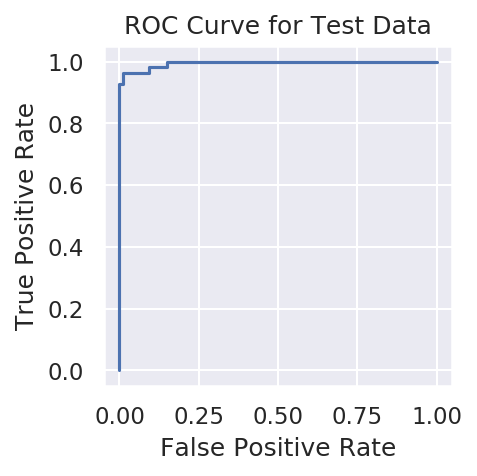

In [153]:
thresholds = np.linspace(0, 1, 101)
TPRs_best_model = []
FPRs_best_model = []
for threshold in thresholds:
    TPR, FPR = compute_model_TPR_FPR(X_allf_scaled_test, y_test, optimal_beta, threshold)
    TPRs_best_model.append(TPR)
    FPRs_best_model.append(FPR)

plt.plot(FPRs_best_model, TPRs_best_model)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data');

For comparison, lets look at the performance of: 
1. Our most sophisticated model: Regularized model using scaled design matrix with all available features and a bias term.
2. Our first model: Unregularized model using only the mean radius and a bias term.

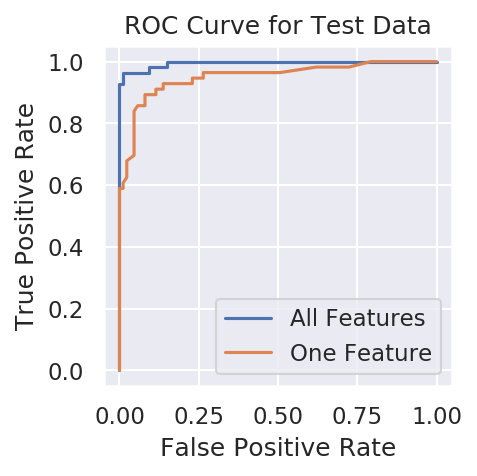

In [154]:
# thresholds = np.linspace(0, 1, 100)
TPRs_one_feature_only = []
FPRs_one_feature_only = []
for threshold in thresholds:
    TPR, FPR = compute_model_TPR_FPR(X_1f_test, y_test, beta_1f, threshold)
    TPRs_one_feature_only.append(TPR)
    FPRs_one_feature_only.append(FPR)

plt.plot(FPRs_best_model, TPRs_best_model)
plt.plot(FPRs_one_feature_only, TPRs_one_feature_only)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['All Features', 'One Feature'])
plt.title('ROC Curve for Test Data');

We see that using all features is clearly much better than using just 1 on the training set.

### Precision Recall Curves

In [155]:
def compute_precision_recall(y_obs, y_hat):
    TP = sum((y_obs == y_hat) & (y_obs == 1))
    FN = sum((y_obs != y_hat) & (y_obs == 1))
    
    TN = sum((y_obs == y_hat) & (y_obs == 0))
    FP = sum((y_obs != y_hat) & (y_obs == 0))
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
       
    return precision, recall

def compute_model_precision_recall(X, y_obs, beta, threshold):    
    y_hat = sigma(X @ beta) > threshold
    guesses = np.round(y_hat)
    return compute_precision_recall(y_obs, y_hat)
    
def print_model_precision_recall(X, y_obs, beta, threshold):
    precision, recall = compute_model_precision_recall(X, y_obs, beta, threshold)
    print(f'precision: {precision * 100:.1f}%, recall: {recall * 100:.1f}%')

In [156]:
print_model_precision_recall(X_allf_scaled_test, y_test, beta_allf_scaled, 0.01)

precision: 82.1%, recall: 98.2%


/home/hug/miniconda2/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in long_scalars



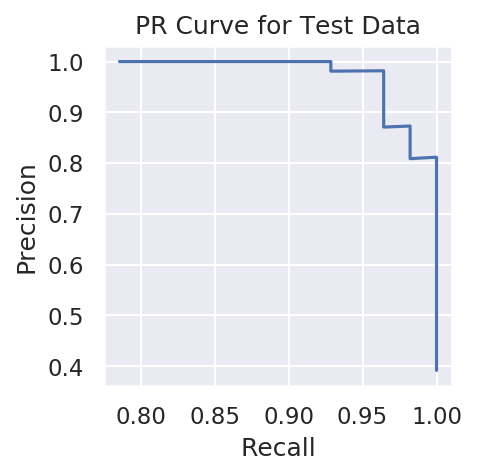

In [157]:
thresholds = np.linspace(0, 1, 101)
precisions_best_model = []
recalls_best_model = []
for threshold in thresholds:
    precision, recall = compute_model_precision_recall(X_allf_scaled_test, y_test, optimal_beta, threshold)
    precisions_best_model.append(precision)
    recalls_best_model.append(recall)

plt.plot(recalls_best_model, precisions_best_model)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for Test Data');

/home/hug/miniconda2/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in long_scalars



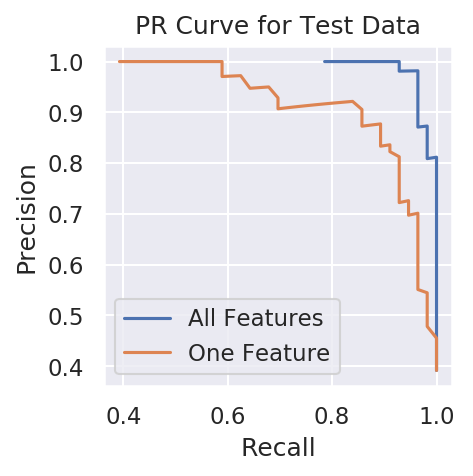

In [158]:
thresholds = np.linspace(0, 1, 101)
precisions_one_feature_only = []
recalls_one_feature_only = []
for threshold in thresholds:
    precision, recall = compute_model_precision_recall(X_1f_scaled_test, y_test, beta_1f_scaled, threshold)
    precisions_one_feature_only.append(precision)
    recalls_one_feature_only.append(recall)


plt.plot(recalls_best_model, precisions_best_model)
plt.plot(recalls_one_feature_only, precisions_one_feature_only)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(['All Features', 'One Feature'])
plt.title('PR Curve for Test Data');

## Extra: Full Derivation of Gradient of Average Cross Entropy Loss

This derivation uses $X$ instead of $\Bbb{X}$, $\beta$ instead of $\vec{\beta}$ and $x_i$ to represent the ith row of the design matrix rather than $\Bbb{X}_i$. 

Sorry about the inconsistent notation, but I took this derivation from Spring 2019, and it didn't seem worth the typesetting time since I'm guessing only a small fraction of you will be interested in all the details of the calculus/algebra.

### Logistic regression summary

First we observe that the logistic or sigmoid function can be written two equivalent ways:

$$\sigma(t) = \frac{1}{1 + \exp(-t)} = \frac{\exp(t)}{1 + \exp(t)} $$

The logistic regression model assumes the following probabilities of $Y \in \{0, 1\}$ given column vector $X$:

\begin{align*}
P(Y=1|X) &= \sigma(X^T \beta) &&= \frac{1}{1 + \exp(-X^T \beta)} &= \frac{\exp(X^T\beta)}{1 + \exp(X^T\beta)} \\[10pt]
P(Y=0|X) &= \sigma(-X^T \beta) &&= \frac{1}{1 + \exp(X^T \beta)}  \\
\end{align*}

The loss most typically used to fit $\beta$ is the log loss or cross-entropy loss, which is the negative log probability of the correct (observed) $Y$ value. This loss for true $Y \in \{0, 1\}$ and predicted probability $\hat Y \in [0, 1]$ is often written:

$$-Y \log(\hat Y) - (1-Y)\log(1- \hat Y)$$

### Empirical Risk

Filling in $\hat Y = P(Y=1|X)$ and filling in the form of the model, we find different ways of expressing the same loss:

\begin{align*}
L(\beta) &= -Y \log(\hat Y) - (1-Y)\log(1- \hat Y) \\[10pt]
         &= - Y \log P(Y=1|X) - (1-Y) \log P(Y=0|X)  \\[10pt]
         &= - Y \log \frac{\exp(X^T\beta)}{1 + \exp(X^T\beta)} - (1-Y) \log \frac{1}{1 + \exp(X^T\beta)}  \\[10pt]
         &= - Y (\log(\exp(X^T\beta)) - \log(1 + \exp(X^T\beta))) - (1-Y) (-\log (1 + \exp(X^T\beta)))  \\[10pt]
         &= - YX^T\beta + Y \log(1 + \exp(X^T\beta))) - Y \log(1 + \exp(X^T\beta))) + \log (1 + \exp(X^T\beta))  \\[10pt]
         &= - YX^T\beta + \log (1 + \exp(X^T\beta)) \\[10pt]
         &= -\left(YX^T\beta + \log \sigma(-X^T\beta)\right)
\end{align*}

Where the last step follows from $\log (1 + \exp(X^T\beta)) = -(- \log (1 + \exp(X^T\beta))) = -\log \frac{1}{1 + \exp(X^T\beta)} = -\log \sigma(-X^T\beta)$.

The empirical risk (average loss across a sample) for a set of observations $(x_1, y_1) \dots (x_n, y_n)$ is often written:

$$R(\beta, x, y) = - \frac{1}{n} \sum_{i=1}^n \left[ y_i x_i^T\beta + \log \sigma(-x_i^T\beta) \right]$$

### Logistic Regression Gradient

Using the logistic regression model and log loss, find the gradient of the empirical risk.

First, we compute the derivative of the sigmoid function since we'll use it in our gradient calculation.

$$
\begin{aligned}
\sigma(t) &= \frac{1}{1 + e^{-t}} \\[10pt]
\sigma'(t) &= \frac{e^{-t}}{(1 + e^{-t})^2} \\[10pt]
\sigma'(t) &= \frac{1}{1 + e^{-t}} \cdot \left(1 - \frac{1}{1 + e^{-t}} \right) \\[10pt]
\sigma'(t) &= \sigma(t) (1 - \sigma(t))
\end{aligned}
$$

As a shorthand, we define $ \sigma_i = \sigma(-x_i^T \beta) $. We will soon need the gradient of $ \sigma_i $ with respect to the vector $ \beta $ so we will derive it now using the chain rule. 

\begin{align*}
\nabla_{\beta} \sigma_i
&= \nabla_{\beta} \sigma(-x_i^T \beta) \\[10pt]
&= \sigma\left(-x_i^T \beta\right) \left(1 - \sigma(-x_i^T \beta)\right)  \nabla_{\beta} \left(-x_i^T \beta\right) \\[10pt]
&= -\sigma_i (1 - \sigma_i) x_i 
\end{align*}

Now, we derive the gradient of the cross-entropy loss with respect to the model parameters $ \boldsymbol{\beta} $. We use the fact that $(1-\sigma_i) = \sigma(x_i^T\beta)$, since $\sigma(x^T\beta) + \sigma(-x^T\beta) = 1$.

\begin{align*}
R(\beta, x, y) &= - \frac{1}{n}\sum_{i=1}^n \left[ y_i x_i^T\beta + \log \sigma_i \right] \\[10pt]
\nabla_{\beta} R(\beta, x, y) &= - \frac{1}{n}\sum_{i=1}^n \left( y_i x_i - \frac{1}{\sigma_i} \sigma_i (1 - \sigma_i) x_i \right) \\[10pt]
                              &= - \frac{1}{n}\sum_{i=1}^n \left( y_i x_i - \sigma(x_i^T\beta) x_i \right) \\[10pt]
                              &= - \frac{1}{n}\sum_{i=1}^n \left(y_i - \sigma(x_i^T\beta)\right) x_i  \\[10pt]
\end{align*}